In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# fecbo-E完成形

## 0828~
マニュアル
m,c,a,bの値を設定する．  

fecbo-dbをirisdデータセットに適用し、遠藤教授が提案した評価方法によって分類結果を評価してみる  
よってfecbo-db(m=3,5,8)とfecbo-e(lambda=10,100)の5種類による結果をcsvファイルに保存することが目的

## 4.fecbo-E(lambda=10)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み
iris = pd.read_csv("../dataset/iris-dataset.csv")
df = iris.drop('species', axis=1)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape

#クラスタ数宣言
c = 3
#Kはクラスタサイズ 
K = X_size /c
#交互最適化最大繰り返し数
max_iter = 100

#ファジィパラメーター設定
m = 3

#正則化パラメーター設定
lam = 10
lam_1= 1/lam

#初期値繰り返し回数
NumberOfRepetitions= 50

In [26]:
#uの最適化部分関数作成
def u_optimize(d,c,lam_1):
    #変数定義
    u_list = [0] * len(d)
    for i in range(len(d)):
        u_list[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += u_list[i]*d[i]-lam_1*(cp.entr(u_list[i]))
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    Positive_Number = []
    Total_1 = []
    Total_K = []
    constraints = []
    #0以上
    for i in range (len(d)):
        Positive_Number.append(u_list[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        sum_iti = 0
        for j in range(c):    
            sum_iti += u_list[i+j]
        Total_1.append(sum_iti==1)
    
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    for i in range(c-1):
        Total_K.append(sum(u_list[i:len(d):c])==K)
        
    constraints.extend(Positive_Number)
    constraints.extend(Total_1)
    constraints.extend(Total_K)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u_list[i].value)
    u_array = u_value.reshape([X_size,c])
    #u_arrayに帰属度配列、resultに目的関数
    return u_array,result

In [27]:
#クラスタ中心計算部分関数作成
def v_calculation(u,c,dimension,X):
    #分母計算(クラスタサイズになるはず)
    v_denominator = np.sum(u,axis=0)
    
    #分子計算
    v_numerator = np.zeros((c,dimension))
    for j in range(c):
        for i in range(X_size):
            v_numerator[j]+= u[i][j]*X[i]
   
    v = np.zeros((c,dimension ))
    for i in range(c):
        v[i] = v_numerator[i]/v_denominator[i]
    return v

In [28]:
for s in range (NumberOfRepetitions):
    print(f"{s+1}回目")
    centroids = X[np.random.choice(X_size,c)]
    # kappa,epsilon = CreateEpsilon(a,b,X_size,dimension)       

    for epoch in range(max_iter):
        #print(f"{epoch+1}回目")
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        u,J = u_optimize(d,c,lam_1)
        #vの更新
        new_centroids = v_calculation(u,c,dimension,X)

        # もしも重心が変わっていなかったら終了
        if np.sum(np.abs(new_centroids-centroids))<=0.000001:
            #print(new_centroids-centroids)
            print("中心が変わらないのでbreakします！")
            break
        centroids = np.copy(new_centroids)

    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if s == 0:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
        best_u = np.copy(u)
    elif best_J > J:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
        best_u = np.copy(u)
    print(f"{s+1}回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

1回目
中心が変わらないのでbreakします！
1回目のクラスタリング結果↓
inf
[[5.006      3.418      1.464      0.244     ]
 [6.70861051 3.01968437 5.54968172 1.9895729 ]
 [5.81538949 2.72431563 4.26231828 1.3624271 ]]
終了
2回目
中心が変わらないのでbreakします！
2回目のクラスタリング結果↓
inf
[[5.006      3.418      1.464      0.244     ]
 [6.70861051 3.01968437 5.54968172 1.9895729 ]
 [5.81538949 2.72431563 4.26231828 1.3624271 ]]
終了
3回目
中心が変わらないのでbreakします！
3回目のクラスタリング結果↓
inf
[[5.006      3.418      1.464      0.244     ]
 [6.70861051 3.01968437 5.54968172 1.9895729 ]
 [5.81538949 2.72431563 4.26231828 1.3624271 ]]
終了
4回目
中心が変わらないのでbreakします！
4回目のクラスタリング結果↓
inf
[[5.006      3.418      1.464      0.244     ]
 [6.70861051 3.01968437 5.54968172 1.9895729 ]
 [5.81538949 2.72431563 4.26231828 1.3624271 ]]
終了
5回目
中心が変わらないのでbreakします！
5回目のクラスタリング結果↓
inf
[[5.006      3.418      1.464      0.244     ]
 [6.70861051 3.01968437 5.54968172 1.9895729 ]
 [5.81538949 2.72431563 4.26231828 1.3624271 ]]
終了
6回目
中心が変わらないのでbreakします！
6回目のクラスタリング結果↓
inf
[[5.006      3.41

In [41]:
print(best_u)

[[ 1.00000000e+00 -3.09134514e-10 -2.38422175e-10]
 [ 1.00000000e+00 -3.07143874e-10 -2.24645351e-10]
 [ 1.00000000e+00 -2.95436702e-10 -2.62634230e-10]
 [ 1.00000000e+00 -3.05241481e-10 -2.27233263e-10]
 [ 1.00000000e+00 -3.06506617e-10 -2.48403790e-10]
 [ 1.00000000e+00 -3.25263709e-10 -1.29359983e-10]
 [ 1.00000000e+00 -3.00477662e-10 -2.52954617e-10]
 [ 1.00000000e+00 -3.12327090e-10 -2.17668292e-10]
 [ 1.00000000e+00 -2.95447189e-10 -2.48559822e-10]
 [ 1.00000000e+00 -3.09580795e-10 -2.16423206e-10]
 [ 1.00000000e+00 -3.18170128e-10 -2.07222159e-10]
 [ 1.00000000e+00 -3.13032148e-10 -2.07169962e-10]
 [ 1.00000000e+00 -3.02503912e-10 -2.39078647e-10]
 [ 1.00000000e+00 -2.66155203e-10 -2.97623941e-10]
 [ 1.00000000e+00 -3.11575619e-10 -2.59403911e-10]
 [ 1.00000000e+00 -3.22833120e-10 -2.08776565e-10]
 [ 1.00000000e+00 -3.12750440e-10 -2.44478412e-10]
 [ 1.00000000e+00 -3.11211044e-10 -2.30248436e-10]
 [ 1.00000000e+00 -3.26277991e-10 -9.58174080e-11]
 [ 1.00000000e+00 -3.14482147e-

[49.99999996 49.99999996 49.99999996]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


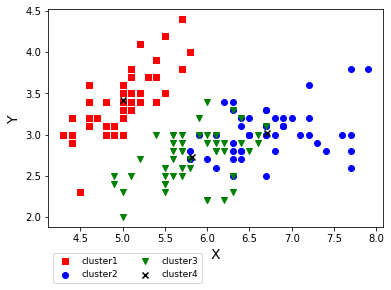

In [29]:
print(np.sum(u, axis=0))#列ごとの総和
print(np.sum(u, axis=1))#行ごとの総和
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
# colors = ['red', 'blue', 'green']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i],alpha=1.0)
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x",alpha = 1.0)
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
#ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9)  # 凡例を表示
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

#fig.savefig("iris_m3.pdf",bbox_inches='tight')

In [46]:
iris = pd.read_csv("../dataset/iris-dataset.csv")
df = iris.drop('species', axis=1)
df

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [47]:
#csvファイル書き出しセル
#pandasで分割結果を記入
df["cluster"]=np_cluster
for i in range(c):
    df["u{}".format(i)] = best_u[:,i]
df.to_csv('fecbo-E-10-iris.csv',index=False)
#目的関数を記入
with open ('fecbo-E-10-iris.csv','a') as f:
    writer = csv.writer(f)
    writer.writerow(["J",best_J])
# print(df.drop(index='J'))

In [48]:
test = pd.read_csv("fecbo-E-10-iris.csv")
test

,sepal_length,sepal_width,petal_length,petal_width,cluster,u0,u1,u2
0,5.1,3.5,1.4,0.2,0.0,1.000000e+00,-3.091345e-10,-2.384222e-10
1,4.9,3.0,1.4,0.2,0.0,1.000000e+00,-3.071439e-10,-2.246454e-10
2,4.7,3.2,1.3,0.2,0.0,1.000000e+00,-2.954367e-10,-2.626342e-10
3,4.6,3.1,1.5,0.2,0.0,1.000000e+00,-3.052415e-10,-2.272333e-10
4,5.0,3.6,1.4,0.2,0.0,1.000000e+00,-3.065066e-10,-2.484038e-10
...,...,...,...,...,...,...,...,...
146,6.3,2.5,5.0,1.9,1.0,-3.663785e-10,9.977901e-01,2.209871e-03
147,6.5,3.0,5.2,2.0,1.0,-3.594523e-10,1.000000e+00,1.185552e-08
148,6.2,3.4,5.4,2.3,1.0,-3.528144e-10,1.000000e+00,3.385297e-09
149,5.9,3.0,5.1,1.8,1.0,-3.670626e-10,9.623473e-01,3.765273e-02


In [30]:
# fig.savefig("fecdb_m3.pdf",bbox_inches='tight')

In [67]:
#クラスター番号ごとに実際に振り分けられた個数を数える
unique, counts = np.unique(np_cluster, return_counts=True)
print(unique)
print(counts)

[0 1 2]
[54 50 46]


##　正解とのクラスター番号を合わせる作業セル

In [69]:
#正解リスト作成
dff = pd.read_csv("../dataset/iris-dataset.csv")
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
seikai = iris["species"].map(size_mapping).values
seikai

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [70]:
np_cluster

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2])

上記の二つのリストを比較してnp_clusterの番号を変更していく

0と1交換

In [71]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==1, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==0, 1, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==100, 0, cluster_hensyuu_1)

In [72]:
cluster_hensyuu_2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2])

In [75]:
#------正解率の算出
dff = pd.read_csv("../dataset/iris-dataset.csv")
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
seikai = iris["species"].map(size_mapping).values

seikaisuu = np.count_nonzero(cluster_hensyuu_2==seikai)
seikairitu= (np.count_nonzero(cluster_hensyuu_2==seikai))/X_size*100
print("正解率")
print(seikairitu)
print("正解数")
print(seikaisuu)
print("クラスタサイズ確認")
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))

正解率
90.66666666666666
正解数
136
クラスタサイズ確認
54
50
46


## ここまで完成形